In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [13]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002716,0.004312,0.002460,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.001107,0.000439,0.029707
1,0.003467,0.003890,0.006787,0.000164,0.000083,0.000042,0.0,0.440006,0.429330,0.511641,0.001107,0.000439,0.029707
2,0.000000,0.011124,0.007768,0.000344,0.000177,0.000090,0.0,0.443880,0.431063,0.518980,0.001107,0.000439,0.029707
3,0.000854,0.004946,0.007238,0.000315,0.000165,0.000085,0.0,0.441573,0.431901,0.509839,0.001107,0.000439,0.029707
4,0.003747,0.004596,0.002107,0.000587,0.000307,0.000158,0.0,0.447507,0.433982,0.522539,0.001107,0.000439,0.029707


In [14]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


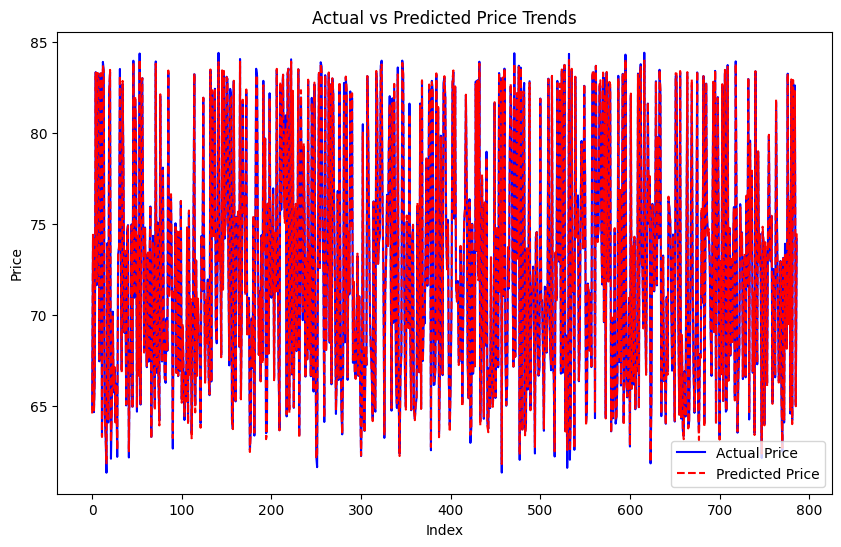

In [15]:
# SVM Model
def svm_model(X, y):
    svm = SVR()
    svm_metrics = {}

    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train the model
    svm.fit(X_train, y_train)
    
    # Evaluate the model on training and testing sets
    y_train_pred = svm.predict(X_train).flatten()
    y_test_pred = svm.predict(X_test).flatten()

    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # After calculating the metrics:
    svm_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)"
        ],
        "Training": [
            train_mae, 
            train_mse, 
            train_mape * 100, 
            train_r2, 
            (1 - train_mape) * 100
        ],
        "Testing": [
            test_mae, 
            test_mse, 
            test_mape * 100, 
            test_r2, 
            (1 - test_mape) * 100
        ]
    }

    # Convert to DataFrame
    svm_metrics = pd.DataFrame(svm_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return svm_metrics


# Assuming X and y are defined
svm_metrics = svm_model(X, y)

With Cross Validation

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def svm_model_cv(X, y):
    # Initialize the SVM Regressor
    svm = SVR()
    
    # Define the cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV

    # Perform cross-validation for MAE and MSE
    mae_scores = -cross_val_score(svm, X, y, scoring='neg_mean_absolute_error', cv=cv)
    mse_scores = -cross_val_score(svm, X, y, scoring='neg_mean_squared_error', cv=cv)
    mape_scores = []
    r2_scores = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the model
        svm.fit(X_train, y_train)
        
        # Predict
        y_pred = svm.predict(X_test)
        
        # Calculate additional metrics
        mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    # Average the metrics across folds
    mean_mae = np.mean(mae_scores)
    mean_mse = np.mean(mse_scores)
    mean_mape = np.mean(mape_scores)
    mean_r2 = np.mean(r2_scores)

    # After calculating the metrics:
    svm_metrics_cv = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)"
        ],
        "Cross-Validation Scores": [
            mean_mae, 
            mean_mse, 
            mean_mape * 100, 
            mean_r2, 
            (1 - mean_mape) * 100
        ]
    }

    # Convert to DataFrame
    svm_metrics_cv = pd.DataFrame(svm_metrics_cv)

    return svm_metrics_cv


# Assuming X and y are defined
svm_metrics_cross_Validation = svm_model_cv(X, y)

In [20]:
svm_metrics

,Metric,Training,Testing
0,Mean Absolute Error (MAE),0.122404,0.130981
1,Mean Squared Error (MSE),0.028771,0.033991
2,Mean Absolute Percentage Error (MAPE),0.170080,0.182292
3,R-squared (R²),0.999392,0.999245
4,Accuracy (1 - MAPE),99.829920,99.817708


In [21]:
svm_metrics_cross_Validation

,Metric,Cross-Validation Scores
0,Mean Absolute Error (MAE),0.122660
1,Mean Squared Error (MSE),0.028765
2,Mean Absolute Percentage Error (MAPE),0.170440
3,R-squared (R²),0.999381
4,Accuracy (1 - MAPE),99.829560
